# Learning Curves for New Text Datasets

We test random selection on various datasets: 

* IMDB
* 20NewsGroups 
* NSF
* Arxiv
* Amazon reviews



In [1]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'
IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))
sys.path.append(os.path.abspath('C:/cygwin/home/mramire8/python_code/structured/'))

from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression



In [2]:
import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 

mpl.style.use('bmh')

vct = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))


def load_data(dataname, path, vct):
    import pickle

    DATA_PKL = path + '/{}data.pkl'.format(dataname)

    if os.path.isfile(DATA_PKL):
        print "Loading existing."
        vct , data = pickle.load(open(DATA_PKL, 'rb'))

        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)

    else:
        data = datautil.load_dataset(dataname, path, categories='religion', rnd=5463, shuffle=True)
        data.train.data = np.array(data.train.data, dtype=object)
        data.test.data = np.array(data.test.data, dtype=object)
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
        pickle.dump((vct, data), open(DATA_PKL, 'wb'))


    return data, vct

def cv_score(clf, data):
    print
    scores = cross_validation.cross_val_score(clf, data.train.bow, data.train.target, cv=5)
    print "BOW - %s" % clf
    print "Data: %s" % len(data.train.target)
    print("Accuracy 5-folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores

def savefig(name):
    plt.savefig("../graphs/"+name + ".pdf", bbox_inches="tight", dpi=200, transparent=True)


In [50]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    from sklearn.learning_curve import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    return test_scores_mean, test_scores_std

font = {'family' : 'Arial',
        'size'   : 16}

mpl.rc('font', **font)
import itertools
def plot_cross_validation(title, test, stdev, ylim=None, train_sizes=np.linspace(.1, 1.0, 5), labels=None):
    cvt = mpl.colors.ColorConverter()
    cls = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    color = itertools.cycle([cvt.to_rgb(c) for c in cls])

    plt.figure(figsize=(1.618*6,6))
    
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    pars2 = {'linewidth': 2,  'mfc': 'white', 'markersize': 9, 
            'mew': 1, 'alpha': 1, 'fillstyle': 'full', 'dash_capstyle': 'round'}
    
    for test_scores_mean, test_scores_std,l in zip(test, stdev, labels):
        current_color = color.next()
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,facecolor=current_color)
        darker = ( max(current_color[0] - .2, 0), max(0, current_color[1] - .2), max(0, current_color[2] - .2))
        pars2.update({'mfc': current_color,'mec': darker})
        plt.plot(train_sizes, test_scores_mean, 'o-', label=l,**pars2)

    plt.legend(loc="best")

    return plt



In [51]:
from sklearn.cross_validation import StratifiedKFold
#np.linspace(.1, 1.0, 5)
def cv_curve(data, n_folds=5, title='', sizes=None):
    skf = StratifiedKFold(data.train.target, n_folds=n_folds,random_state=1233333, shuffle=True)
    title = "Learning Curves MNB and LR - %s" % title 
    if sizes is None:
        sizes = range(50, min(2001, len(data.train.target)/5*4), 100)
    nb = MultinomialNB()
    avg1, std1 = plot_learning_curve(nb, title, data.train.bow, data.train.target, ylim=(0.45, 1.01), cv=skf, 
                                     n_jobs=1, train_sizes=sizes)

    lr  = LogisticRegression(penalty='l1')
    avg2, std2 = plot_learning_curve(lr, title, data.train.bow, data.train.target, (0.45, 1.01), cv=skf, 
                                     n_jobs=1, train_sizes=sizes)

    plot_cross_validation(title,[avg1, avg2], [std1, std2], (0.45, 1.01), 
                          train_sizes=sizes,
                          labels=["{}-a={}".format(nb.__class__.__name__, nb.alpha),
                                  "{}-Penalty={}-C={}".format(lr.__class__.__name__, lr.penalty, lr.C)] )

In [6]:

data, vct = load_data('imdb', IMDB_DATA, vct)


clfnb = MultinomialNB(fit_prior=True)
clflr = LogisticRegression(penalty='l1')
clfnb = MultinomialNB(fit_prior=True)

cv_score(clfnb, data)
    
cv_score(MultinomialNB(class_prior=[.5,.5]), data)

cv_score(LogisticRegression(penalty='l2'), data)



BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 24991
Accuracy 5-folds: 0.84 (+/- 0.01)


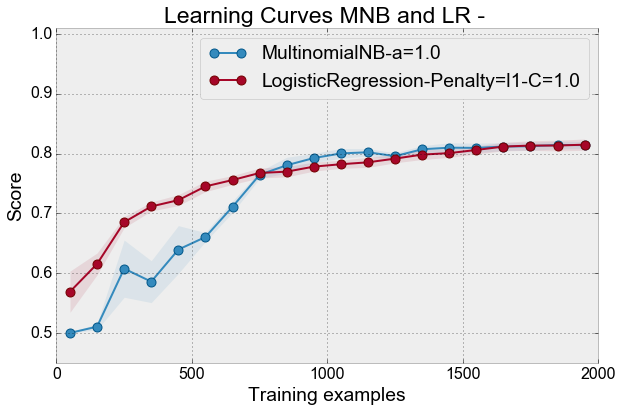

In [9]:
cv_curve(data, n_folds=5)
cv_score(MultinomialNB(), data)
savefig('imdb')
#load other datset, test classifier
#arxiv

In [10]:
data.train.bow.shape

(24991, 44996)

Loading existing.


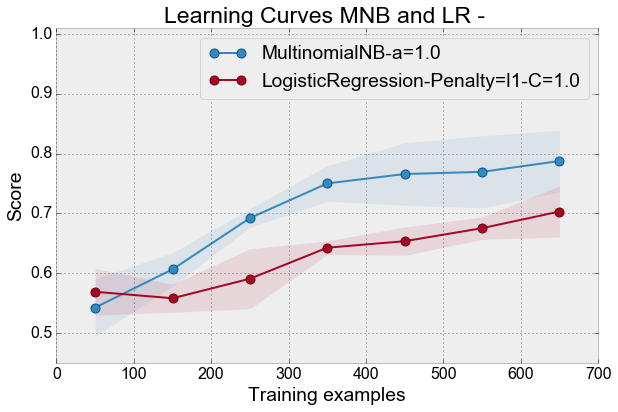

In [25]:
vct2 = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))

ng20, vct2 = load_data('20news', '.', vct2)
cv_curve(ng20, n_folds=5)
savefig('20news')

In [12]:
cv_score(MultinomialNB(),ng20)
cv_score(LogisticRegression(penalty='l1'),ng20)
cv_score(LogisticRegression(penalty='l2'),ng20)


BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 828
Accuracy 5-folds: 0.79 (+/- 0.10)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 828
Accuracy 5-folds: 0.69 (+/- 0.09)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 828
Accuracy 5-folds: 0.73 (+/- 0.06)


array([ 0.69879518,  0.73493976,  0.70481928,  0.78181818,  0.72727273])

In [5]:
# Amazon fine food reviews

import sqlite3
import string
from sklearn.datasets import base as bunch

AMAZON_DATA='/Users/maru/MyCode/data/amazon-fine-foods'
AMAZON_DATA='C:/Users/mramire8/Google Drive/data/amazon-fine-foods'
def load_amazonfood(path, vct):
    rnd = np.random.RandomState(12756)
    con = sqlite3.connect(path + '/database.sqlite')

    def partition(x):
        if x < 3:
            return 0
#             return 'negative'
        return 1
#         return 'positive'

    res = con.execute("SELECT Score, Text FROM Reviews WHERE Score !=3")
#     res = con.execute("SELECT Score FROM Reviews WHERE Score !=3")

    messages={'Score': [], 'Text':[]}

    for row in res:
        messages['Score'].append(row[0])
        messages['Text'].append(row[1])


    Score = np.array(messages['Score'])
    Score = np.array(map(partition, Score))
    # Summary = messages['Summary']
    Text = np.array(messages['Text'])
    message = None
#     print len(Score), len(Text)

    return Score, Text
#     return Score, Text

vct3 = CountVectorizer(encoding='ISO-8859-1',min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))

# amazon, vct3 = load_amazonfood(AMAZON_DATA,  vct3)
score, text  = load_amazonfood(AMAZON_DATA,  vct3)

# cv_curve(amazon, n_folds=5)



In [9]:
from collections import Counter 

c = Counter(score)

print c.most_common(5)

[(1, 443777), (0, 82037)]


In [15]:
print 82037./(443777+82037), 443777+82037

0.156019048561 525814


In [16]:
vct3 = CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))
food = vct3.fit_transform(text)


In [32]:
def balanced_subsample(y,subsample_size=1.0, seed=554433):
    rnd = np.random.RandomState(seed)
    class_xs = []
    min_elems = None
    idx = np.array(range(len(y)))
    for yi in np.unique(y):
        elems = idx[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            rnd.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

sampled_index, sampled_target = balanced_subsample(score, subsample_size=1.)

# pos = [i for i,s in enumerate(score) if s == 'positive']
# neg = [i for i,s in enumerate(score) if s == 'negative']
# rnd.shuffle(pos)
# rnd.shuffle(neg)
# new_sample = pos[:len(neg)][:30000] + neg[:30000]
# # rnd.shuffle(new_sample)
# sampled = food[new_sample]
# sampled_target= score[new_sample]
# tmp_data = bunch.Bunch(train=bunch.Bunch(bow=sampled, target=sampled_target))
# cv_curve(, n_folds=5)


In [33]:
print len(sampled_target)
print sampled_index[-10:]
print sampled_target[:10]
print len(sampled_index)
print len(text)
print max(sampled_index)


164074
[330610 176864 281135  17047 394897 465530 215848 525481 184239 192244]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
164074
525814
525811


In [84]:
import pickle

pickle.dump( sampled_target, open("amazon_sampled_target.pkl", 'wb'), protocol=2)
# pickle.dump(text[sampled_index], open("amazon_sampled_text.pkl", 'wb'), protocol=2)


In [35]:
with open("amazon_sampled_text.txt", 'w') as f:
    for t in sampled_index: 
#         print t
        f.write(text[t].encode('latin1'))
        f.write("\n")

print "done."

done.


In [83]:
print sampled_target[:10]
print text[sampled_index[2]]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.


In [36]:
vct3 = CountVectorizer(encoding='ISO-8859-1',min_df=5, token_pattern=re.compile(r'(?u)\b\w+\b'), binary=True)
def subsample_text(text, index):
    for i in index:
        yield text[i]

amazon_bow = vct3.fit_transform(subsample_text(text, sampled_index))



In [44]:
rnd2 = np.random.RandomState(3637)
perm = rnd2.permutation(range(len(sampled_target)))

tmp_data = bunch.Bunch(train=bunch.Bunch(bow=amazon_bow[perm], target=sampled_target[perm]))


In [67]:
from collections import Counter
c = Counter()
for t in subsample_text(text, sampled_index):
    c.update([len(t.split())])
    
print c.most_common(5)
print c.most_common()[:-5-1:-1]

[(25, 2655), (23, 2645), (22, 2621), (21, 2604), (27, 2488)]
[(1901, 1), (1751, 1), (1612, 1), (607, 1), (1535, 1)]


In [99]:
sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
sent_c = Counter()
word_c = Counter()
for t in subsample_text(text, sampled_index):
    s = sent_tk.tokenize_sents([t])
    sent_c.update([len(s[0])])
    word_c.update([len(ss.split()) for ss in s[0]])
    

In [108]:
print sent_c.most_common(5)
print word_c.most_common(5)
print "Aveg. number of sentences per document %s" % (np.average(sent_c.keys(), weights=sent_c.values()))
print "Aveg. number of words per sentence %s" % (np.average(word_c.keys(), weights=word_c.values()))
print "Total sentences %s" % (sum(k*v for k,v in sent_c.items()))
print "St. sentences %s" % (np.std([[k]*v for k,v in sent_c.items()]))

[(3, 31602), (4, 27458), (2, 22715), (5, 20667), (6, 14891)]
[(10, 41521), (11, 40981), (9, 40104), (12, 39472), (13, 39159)]
Aveg. number of sentences per document 5.13456123456
Aveg. number of words per sentence 16.1384097297
Total sentences 842448


TypeError: unsupported operand type(s) for /: 'list' and 'long'

In [97]:
[len(ss.split()) for ss in s[0]]

[32, 10, 9, 10, 16, 17, 18, 10, 16, 23, 10, 8, 29, 4]

Average length 82.801321355


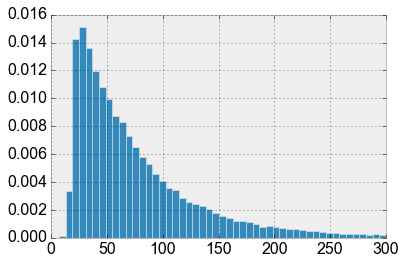

In [76]:
plt.hist(c.keys(),weights=c.values(), range=(1, 300), bins=50, normed=True)
# plt.xlim([0,1000])
print "Average %s" % np.average(c.keys(), weights=c.values())
su = 0
for k,v in c.items():
    su += k * v
print 1. * su / sum(c.values())

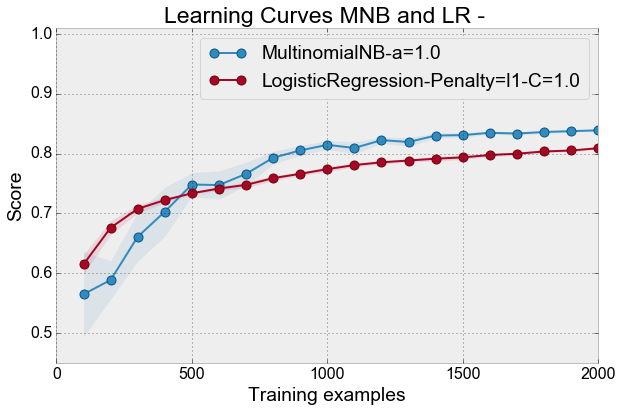

In [52]:
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression

sizes = range(100, 2001, 100)
cv_curve(tmp_data, n_folds=5, sizes = sizes)
savefig("amazon")

In [85]:
cv_score(MultinomialNB(),tmp_data)
cv_score(MultinomialNB(alpha=0.1),tmp_data)
cv_score(LogisticRegression(penalty='l1'),tmp_data)


BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 164074
Accuracy 5-folds: 0.88 (+/- 0.01)

BOW - MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Data: 164074
Accuracy 5-folds: 0.88 (+/- 0.01)

BOW - LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Data: 164074
Accuracy 5-folds: 0.91 (+/- 0.00)


array([ 0.9086726 ,  0.90724037,  0.90644237,  0.91098312,  0.90756994])

In [ ]:
cc = Counter(score[idx])
print cc.most_common(3)

In [86]:
def read_data(filename):
    all_data = gzip.open(filename, 'rt').readlines()
    return all_data
def read_data_target(filename):
    target = pickle.load(open(filename, 'rb'))
    return target

In [ ]:
def print_top_terms(model, terms, n=20):
    print '\nTop Coefficients'
    coef = model.coef_[0]
    srted = np.argsort(coef)
    topi = srted[::-1][:n]
    boti = srted[:n]
    terms = np.array(terms)
    #"\n".join('%s\t%.2f' % (names[j], coef[j]) for j in np.argsort(coef)[::-1] if coef[j] != 0)
    print 'Class-0 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[topi], coef[topi]) if c != 0)
    print '\nClass-1 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[boti], coef[boti]) if c != 0)
    print '\nintercept=%g' % model.intercept_

def print_terms_and_coef(row, terms, coef):
    indices = sorted(row.indices, key=lambda x: coef[x])
    print 'Top Terms:'
    for i in indices:
        if coef[i] != 0:
            print terms[i], "%.3f" % coef[i]
    print
print 

In [ ]:
model = LogisticRegression(penalty='l1').fit(sampled, sampled_target)
model = MultinomialNB().fit(sampled, sampled_target)
print_top_terms(model, vct3.get_feature_names(), n=10)

In [10]:
ARXIV_DATA= '/Users/maru/MyCode/data/arxiv'
from sklearn.datasets import load_files
def load_arxiv(path, category=None, subset="all", shuffle=True, rnd=2356, percent=.5):
    """
    load text files from Aviation-auto dataset from folders to memory. It will return a 25-75 percent train test split
    :param path: path of the root directory of the data
    :param subset: what data will be loaded, train or test or all
    :param shuffle:
    :param rnd: random seed value
    :param vct: vectorizer
    :return: :raise ValueError:
    """
    from sklearn.cross_validation import ShuffleSplit

    categories = {'ai': ['cs.AI', 'cs.LG'],
                  'ai2': ['cs.AI', 'stat.ML'],
                  'ml': ['stat.ML', 'cs.LG'],
                  'co':['cs.CC','cs.LO'],
                  'db2':['cs.DB','cs.SE'],
                  'la':['cs.CL','cs.SE'],
                  'db': ['cs.DB', 'cs.IR'],
                  'cl':['cs.CL','stat.ML'],
    }

    cat = category
#     if category is not None:
#         cat = categories[category]

    data = bunch.Bunch()

    if subset in ('train', 'test'):
        raise ValueError("We are not ready for train test aviation data yet")
    elif subset == "all":
        data = load_files(path, encoding="latin1", load_content=True, random_state=rnd, categories=cat)
        data.data = np.array(data.data, dtype=object)
    else:
        raise ValueError("Subset can only be 'train', 'test' or 'all', got '%s'" % subset)

    indices = ShuffleSplit(len(data.data), n_iter=1, test_size=percent, random_state=rnd)
    for train_ind, test_ind in indices:
        data = bunch.Bunch(train=bunch.Bunch(data=data.data[train_ind], target=data.target[train_ind],
                                             filenames=data.filenames[train_ind], target_names=data.target_names),
                           test=bunch.Bunch(data=data.data[test_ind], target=data.target[test_ind],
                                            filenames=data.filenames[test_ind], target_names=data.target_names))

    if shuffle:
        random_state = np.random.RandomState(rnd)
        indices = np.arange(data.train.target.shape[0])
        random_state.shuffle(indices)
        data.train.filenames = data.train.filenames[indices]
        data.train.target = data.train.target[indices]
        # Use an object array to shuffle: avoids memory copy
        data_lst = np.array(data.train.data, dtype=object)
        data_lst = data_lst[indices]
        data.train.data = data_lst
        data.test.data = np.array(data.test.data, dtype=object)

    return data

********************
['cs.AI', 'stat.ML']
Label distribution: 0.498623387915

BOW - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Data: 6901
Accuracy 5-folds: 0.89 (+/- 0.02)


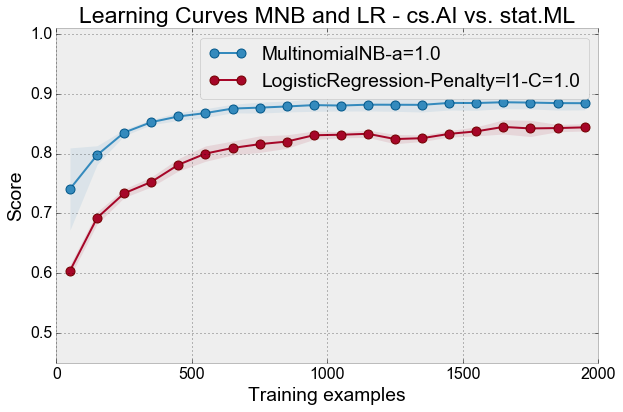

In [11]:
cats = ['cs.AI', 'cs.CC', 'cs.CL', 'cs.CR', 'cs.DB', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'stat.ML', 
        'cs.NI', 'cs.GT', 'cs.MA', 'cs.PL', 'cs.SE', 'cs.NE', 'cs.PF', 'cs.SI']


from itertools import combinations

combs = combinations(cats, 2)

combs = [['cs.DB','cs.IR'],['cs.DB','cs.SI'],['cs.IR','cs.NE'],
         ['cs.LO','cs.PL'],['cs.NE','cs.SI'],['cs.SE','cs.SI']]
combs = [['cs.AI',vs] for vs in ['cs.CR', 'cs.DB', 'cs.GT', 'cs.IR', 'cs.LG', 'cs.LO', 'cs.NE', 'cs.PL', 'stat.ML']]
combs = [['cs.AI',vs] for vs in ['cs.DB', 'cs.LG', 'cs.LO', 'stat.ML']]

# combs = [['cs.SI',vs] for vs in ['cs.IR', 'cs.LG', 'cs.NE', 'stat.ML']]
combs= [['cs.AI','stat.ML']]


for com in combs:
    try:
        print "*" * 20
        print com
        arxiv1 = load_arxiv(ARXIV_DATA, category=com)
        vct4= CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))
        arxiv1.train.bow = vct4.fit_transform(arxiv1.train.data)
        print "Label distribution: %s" % (1. * sum(arxiv1.train.target)/ len(arxiv1.train.target))
        cv_score(MultinomialNB(),arxiv1)
        cv_curve(arxiv1, n_folds=5, title="{} vs. {}".format(*com))
#         savefig("{}-{}".format(*com))
    except ValueError:
        print "error", com


In [28]:
def test_firstk(data, vct):
    vct1 = CountVectorizer(encoding='ISO-8859-1', min_df=5, max_df=1.0, ngram_range=(1,1),
                      token_pattern=re.compile(r'(?u)\b\w+\b'))
    docs = vct1.fit_transform(data.train.data)
    arx = MultinomialNB().fit(docs, data.train.target)
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
    arxsent = _sentences(data.train.data,sent_tk)

    for i in range(1,6):

    # first1= [doc[0] for doc in  arxsent]
    # f1bow = vct4.transform(first1)
    # print metrics.accuracy_score(arxiv1.train.target, arx.predict(f1bow))

        first5= [". ".join(doc[:i]) for doc in  arxsent]
        f5bow = vct1.transform(first5)
        print "First-%s" % i,  metrics.accuracy_score(data.train.target, arx.predict(f5bow))

In [29]:
test_firstk(arxiv1, vct4)

First-1 0.864077669903
First-2 0.881466454137
First-3 0.892479350819
First-4 0.902622808289
First-5 0.907259817418


In [30]:
test_firstk(ng20, vct2)

First-1 0.752415458937
First-2 0.803140096618
First-3 0.832125603865
First-4 0.855072463768
First-5 0.861111111111


In [27]:
print vct4

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None,
        token_pattern=<_sre.SRE_Pattern object at 0x10692a420>,
        tokenizer=None, vocabulary=None)


In [13]:


# Get the sentences for testing
def _sentences(docs, sent_tk):
    data = []
    sent = sent_tk.tokenize_sents(docs)
#     for sentences in sent:
#         data.extend(sentences)
    data = sent
    return data

def stats_data(data_text):
    sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
    snip = _sentences(data_text, sent_tk)
    sent = [len(d) for d in snip]
    sent_words = [len(s.split())  for d in snip for s in d]
    doc_words = [len(d.split()) for d in data_text]
    
    stat = {'N': [len(data_text),''], 
            'n_sent':[sum(sent),''], 
            'ave_n_sent':[np.mean(sent),np.std(sent)], 
            'ave_sent_word':[np.mean(sent_words),np.std(sent_words)],
            'ave_doc_word':[np.mean(doc_words),np.std(doc_words)]
            }
    return stat



In [ ]:
# print data.train.keys()
#tabulate( average / average.sum() ,headers=['neg', 'pos','neu'], floatfmt=".4f")
from tabulate import tabulate 
# print "imdb"
# print tabulate(stats_data(data.train.data), headers=['Avg.N.Sent','Ave.Words/sent','Total Sent.','N.Documents','Ave.Words/doc'])
# print "arxiv"
# print tabulate(stats_data(arxiv1.train.data), headers=['Avg.N.Sent','Ave.Words/sent','Total Sent.','N.Documents','Ave.Words/doc'])
# print "20news"
# print tabulate(stats_data(ng20.train.data), headers=['Avg.N.Sent','Ave.Words/sent','Total Sent.','N.Documents','Ave.Words/doc'])

names = ['imdb', 'arxiv','20news']
for n, d in zip(names,[data.train.data, arxiv1.train.data, ng20.train.data]):
    res = stats_data(d)
    print 
    print n
    print tabulate([[k, "%s (+/- %s)" % (v[0], v[1]) ] for k,v in sorted(res.items())], headers=['Stat','Value'])

In [ ]:
print 1. * sum(data.train.target)/len(data.train.target)
print 1. * sum(arxiv1.train.target)/len(arxiv1.train.target)
print 1. * sum(ng20.train.target)/len(ng20.train.target)

In [ ]:
print len(text)
res = stats_data(text)
print 
print n
print tabulate([[k, "%s (+/- %s)" % (v[0], v[1]) ] for k,v in sorted(res.items())], headers=['Stat','Value'])

In [ ]:
c=Counter(food_data.train.target)
print 1. * c['negative']/sum(c.values())

In [ ]:
food_data.train.target[:3]

In [ ]:
print text[:10]